<a href="https://colab.research.google.com/github/mottasilvia/UCU-NLP/blob/main/Proyecto%20Final/PLN_Proyecto_Final_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PLN_Proyecto_Final_LSTM.ipynb

El objetivo de este notebook es clasificar mensajes de texto en diferentes categorías utilizando redes neuronales recurrentes (RNN) con Long Short-Term Memory (LSTM) y varios enfoques respecto a los embeddings: embeddings aleatorios entrenados desde cero y embeddings preentrenados de Word2Vec

| **Clase**                    | **Precision (RNN)** | **Recall (RNN)** | **F1-score (RNN)** | **Support (RNN)** | **Precision (Word2Vec)** | **Recall (Word2Vec)** | **F1-score (Word2Vec)** | **Support (Word2Vec)** |
|------------------------------|---------------------|------------------|--------------------|-------------------|-------------------------|----------------------|------------------------|------------------------|
| agradecimiento o saludo      | 0.90                | 0.93             | 0.91               | 470               | 0.89                    | 0.93                 | 0.91                   | 470                    |
| baja                         | 0.91                | 0.71             | 0.80               | 14                | 1.00                    | 0.43                 | 0.60                   | 14                     |
| equivocado                   | 0.73                | 0.57             | 0.64               | 14                | 1.00                    | 0.14                 | 0.25                   | 14                     |
| glicemia                     | 1.00                | 0.12             | 0.22               | 16                | 0.40                    | 0.12                 | 0.19                   | 16                     |
| medicación o turno           | 0.58                | 0.56             | 0.57               | 39                | 0.35                    | 0.49                 | 0.41                   | 39                     |
| optin                        | 0.96                | 0.90             | 0.93               | 368               | 0.98                    | 0.89                 | 0.93                   | 368                    |
| otros                        | 0.65                | 0.69             | 0.67               | 62                | 0.78                    | 0.40                 | 0.53                   | 62                     |
| respuesta                    | 0.82                | 0.87             | 0.84               | 422               | 0.75                    | 0.87                 | 0.81                   | 422                    |
| nan                          | 0.50                | 0.33             | 0.40               | 6                 | 0.60                    | 0.50                 | 0.55                   | 6                      |
| **accuracy**                 |                     |                  | 0.87               | 1411              |                         |                      | 0.84                   | 1411                   |
| **macro avg**                | 0.78                | 0.63             | 0.67               | 1411              | 0.75                    | 0.53                 | 0.58                   | 1411                   |
| **weighted avg**             | 0.87                | 0.87             | 0.86               | 1411              | 0.85                    | 0.84                 | 0.84                   | 1411                   |


In [ ]:
# pandas, openpyxl y emoji
!pip install pandas openpyxl emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
# Importación de librerías y configuración inicial
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

# Verificar la disponibilidad de la GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

# Montar Google Drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/UCU-NLP/mensajes_trabajo_final.xlsx'

# Cargar el archivo Excel
data = pd.read_excel(file_path)
print("Datos cargados:")
print(data.head())

# Diccionario de traducciones de emojis de inglés a español
emoji_translations = {
    ":grinning_face:": ":cara_sonriendo:",
    # (añadir todas las traducciones necesarias)
}

# Función para convertir emoticones a texto y luego traducirlos al español
def convertir_emoticones(texto):
    if isinstance(texto, str):
        texto_emoji = emoji.demojize(texto, delimiters=(":", ":"))
        for en, es in emoji_translations.items():
            texto_emoji = texto_emoji.replace(en, es)
        return texto_emoji
    else:
        return texto

# Aplicar la función para convertir emoticones a la columna 'recibido'
data['recibido'] = data['recibido'].apply(convertir_emoticones)
print("Datos después de convertir emoticones a texto:")
print(data.head())

# Eliminar las filas con valores nulos en la columna 'tipo'
data_limpia = data.dropna(subset=['tipo'])
print(f"Cantidad de filas antes de la limpieza: {data.shape[0]}")
print(f"Cantidad de filas después de la limpieza: {data_limpia.shape[0]}")

# Crear un nuevo DataFrame solo con las columnas 'recibido' y 'clase'
df = data[['recibido', 'clase']]



# Agrupar clases similares
df.loc[df['clase'] == 'agradecimiento', 'clase'] = 'agradecimiento o saludo'
df.loc[df['clase'] == 'saludo', 'clase'] = 'agradecimiento o saludo'
df.loc[df['clase'] == 'medicación', 'clase'] = 'medicación o turno'
df.loc[df['clase'] == 'turno', 'clase'] = 'medicación o turno'
df.loc[df['clase'] == 'queja', 'clase'] = 'otros'
df.loc[df['clase'] == 'pregunta', 'clase'] = 'otros'
df.loc[df['clase'] == 'autorespuesta', 'clase'] = 'otros'
df.loc[df['clase'] == 'respuesta a consejo o pregunta', 'clase'] = 'respuesta'


# Visualización de la distribución de clases
class_counts = df['clase'].value_counts().sort_index()
print(class_counts)


Num GPUs Available:  0
Please install GPU version of TF
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Datos cargados:
   id_participante  id_mensaje  \
0               43         223   
1              265        1056   
2              425        1575   
3              429        1590   
4              921        3030   

                                             enviado       tipo subtipo  \
0   ¡Limpiar la casa, subir escaleras, trabajar e...  educativo       0   
1   ¡Limpiar la casa, subir escaleras, trabajar e...  educativo       0   
2   ¡Limpiar la casa, subir escaleras, trabajar e...  educativo       0   
3   ¡Limpiar la casa, subir escaleras, trabajar e...  educativo       0   
4   ¡Limpiar la casa, subir escaleras, trabajar e...  educativo       0   

                                            recibido  \
0                                               👍🏽🫶🏽   
1                              

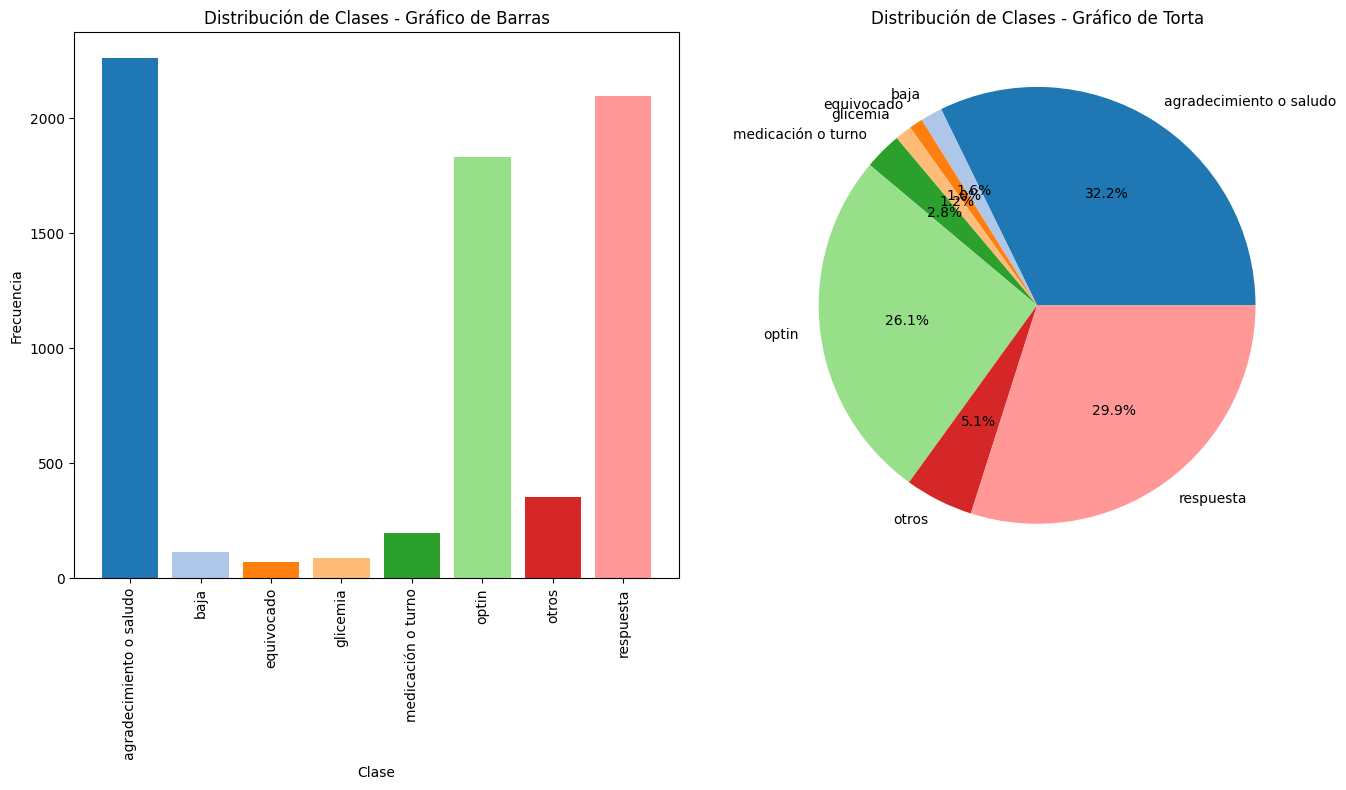

Non-string values in 'recibido': 782    9
Name: recibido, dtype: object


<ipython-input-5-e47911092d37>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recibido'] = df['recibido'].apply(lambda x: x if isinstance(x, str) else '')


In [ ]:

colors = plt.get_cmap('tab20')
fig, ax = plt.subplots(1, 2, figsize=(14, 8))
ax[0].bar(class_counts.index, class_counts.values, color=colors(range(len(class_counts))))
ax[0].set_title('Distribución de Clases - Gráfico de Barras')
ax[0].set_xlabel('Clase')
ax[0].set_ylabel('Frecuencia')
ax[0].tick_params(axis='x', rotation=90)
ax[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%', colors=colors(range(len(class_counts))))
ax[1].set_title('Distribución de Clases - Gráfico de Torta')
plt.tight_layout()
plt.show()


# Verificar y convertir el tipo de dato de la columna 'recibido' a string si es necesario
if df['recibido'].dtype != object:
    df['recibido'] = df['recibido'].astype(str)
non_string_values = df['recibido'][~df['recibido'].apply(lambda x: isinstance(x, str))]
print("Non-string values in 'recibido':", non_string_values)
df['recibido'] = df['recibido'].apply(lambda x: x if isinstance(x, str) else '')

# Vectorización del texto usando TF-IDF
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(df['recibido'])
y = df['clase']
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Tokenización y secuencias para redes neuronales
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['recibido'])
X_seq = tokenizer.texts_to_sequences(df['recibido'])
max_length = max([len(x) for x in X_seq])
X_padded = pad_sequences(X_seq, maxlen=max_length)
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_padded, y, test_size=0.2, random_state=42)


# Convertir etiquetas a numéricas
le = LabelEncoder()
y_train_seq = le.fit_transform(y_train_seq.astype(str)) # Asegurar que las etiquetas son de tipo string
y_test_seq = le.transform(y_test_seq.astype(str)) # Asegurar que las etiquetas son de tipo string


# Embeddings Aleatorios Entrenados desde Cero





In [ ]:


# Creación del modelo RNN (LSTM)
def create_rnn_model():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model

# Entrenamiento y evaluación del modelo RNN (LSTM)
rnn_model = create_rnn_model()
rnn_model.fit(X_train_seq, y_train_seq, epochs=5, batch_size=64, validation_split=0.1)
y_pred_rnn = rnn_model.predict(X_test_seq)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
print("RNN (LSTM) Model")
print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_rnn)}")
print(classification_report(y_test_seq, y_pred_rnn, target_names=le.classes_))


Epoch 1/5
80/80 [==============================] - 96s 1s/step - loss: 1.2993 - accuracy: 0.5818 - val_loss: 0.7935 - val_accuracy: 0.7535
Epoch 2/5
80/80 [==============================] - 72s 897ms/step - loss: 0.6857 - accuracy: 0.7971 - val_loss: 0.6489 - val_accuracy: 0.8067
Epoch 3/5
80/80 [==============================] - 74s 923ms/step - loss: 0.5498 - accuracy: 0.8310 - val_loss: 0.5833 - val_accuracy: 0.8156
Epoch 4/5
80/80 [==============================] - 74s 932ms/step - loss: 0.4250 - accuracy: 0.8729 - val_loss: 0.5264 - val_accuracy: 0.8404
Epoch 5/5
45/45 [==============================] - 5s 101ms/step
RNN (LSTM) Model
Accuracy: 0.8660524450744153


TypeError: object of type 'float' has no len()

In [ ]:
# Imprimir el reporte de clasificación
print("RNN (LSTM) Model")
print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_rnn)}")
print(classification_report(y_test_seq, y_pred_rnn, target_names=le.classes_.astype(str))) # Asegurar que las etiquetas son de tipo string

RNN (LSTM) Model
Accuracy: 0.8660524450744153
                         precision    recall  f1-score   support

agradecimiento o saludo       0.90      0.93      0.91       470
                   baja       0.91      0.71      0.80        14
             equivocado       0.73      0.57      0.64        14
               glicemia       1.00      0.12      0.22        16
     medicación o turno       0.58      0.56      0.57        39
                  optin       0.96      0.90      0.93       368
                  otros       0.65      0.69      0.67        62
              respuesta       0.82      0.87      0.84       422
                    nan       0.50      0.33      0.40         6

               accuracy                           0.87      1411
              macro avg       0.78      0.63      0.67      1411
           weighted avg       0.87      0.87      0.86      1411



# Embeddings preentrenados de Word2Vec

Word2Vec ha sido entrenado en un vasto corpus de noticias y proporciona representaciones vectoriales para 3 millones de palabras y frases.

In [ ]:
import gensim.downloader as api

# Descargar el modelo preentrenado de Word2Vec
word2vec = api.load("word2vec-google-news-300")

# Verificación
print(f"Word2Vec model loaded with {len(word2vec.index_to_key)} words")


[==================================================] 100.0% 1662.8/1662.8MB downloaded
Word2Vec model loaded with 3000000 words


In [ ]:
import numpy as np

# Crear la matriz de embeddings
embedding_dim = 300
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word2vec:
        embedding_matrix[i] = word2vec[word]
    else:
        embedding_matrix[i] = np.random.randn(embedding_dim)  # Opcionalmente, se pueden usar vectores aleatorios

# Verificación
print(f"Embedding matrix shape: {embedding_matrix.shape}")


Embedding matrix shape: (3229, 300)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.optimizers import Adam

# Definir el modelo con embeddings preentrenados
def create_rnn_model_with_pretrained_embeddings():
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,
                        output_dim=embedding_dim,
                        weights=[embedding_matrix],
                        input_length=max_length,
                        trainable=False))  # Ajustar a True si deseas que los embeddings se actualicen durante el entrenamiento
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    return model



In [ ]:
# Crear el modelo
rnn_model_pretrained = create_rnn_model_with_pretrained_embeddings()

In [ ]:

# Entrenar el modelo
rnn_model_pretrained.fit(X_train_seq, y_train_seq, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
80/80 [==============================] - 138s 2s/step - loss: 1.0674 - accuracy: 0.6791 - val_loss: 0.7641 - val_accuracy: 0.7624
Epoch 2/5
80/80 [==============================] - 125s 2s/step - loss: 0.7128 - accuracy: 0.7835 - val_loss: 0.6594 - val_accuracy: 0.7926
Epoch 3/5
80/80 [==============================] - 130s 2s/step - loss: 0.6068 - accuracy: 0.8097 - val_loss: 0.6098 - val_accuracy: 0.8014
Epoch 4/5
80/80 [==============================] - 147s 2s/step - loss: 0.5329 - accuracy: 0.8359 - val_loss: 0.5725 - val_accuracy: 0.8191
Epoch 5/5
80/80 [==============================] - 150s 2s/step - loss: 0.4832 - accuracy: 0.8473 - val_loss: 0.5754 - val_accuracy: 0.8103


In [ ]:
# Evaluación del modelo
y_pred_rnn = rnn_model_pretrained.predict(X_test_seq)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
print("RNN (LSTM) Model with Pretrained Word2Vec Embeddings")
print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_rnn)}")
print(classification_report(y_test_seq, y_pred_rnn, target_names=le.classes_))


45/45 [==============================] - 15s 328ms/step
RNN (LSTM) Model with Pretrained Word2Vec Embeddings
Accuracy: 0.8405386250885897


TypeError: object of type 'float' has no len()

In [ ]:
# Evaluación del modelo
y_pred_rnn = rnn_model_pretrained.predict(X_test_seq)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
print("RNN (LSTM) Model with Pretrained Word2Vec Embeddings")
print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_rnn)}")

# Convert le.classes_ to a list of strings if it's not already
if not isinstance(le.classes_[0], str):
    target_names = [str(class_name) for class_name in le.classes_]
else:
    target_names = le.classes_

print(classification_report(y_test_seq, y_pred_rnn, target_names=target_names))

45/45 [==============================] - 9s 191ms/step
RNN (LSTM) Model with Pretrained Word2Vec Embeddings
Accuracy: 0.8405386250885897


TypeError: object of type 'float' has no len()

In [ ]:
# Evaluación del modelo
y_pred_rnn = rnn_model_pretrained.predict(X_test_seq)
y_pred_rnn = np.argmax(y_pred_rnn, axis=1)
print("RNN (LSTM) Model with Pretrained Word2Vec Embeddings")
print(f"Accuracy: {accuracy_score(y_test_seq, y_pred_rnn)}")

# Ensure target_names is a list of strings
target_names = [str(class_name) for class_name in le.classes_]

print(classification_report(y_test_seq, y_pred_rnn, target_names=target_names))

45/45 [==============================] - 21s 457ms/step
RNN (LSTM) Model with Pretrained Word2Vec Embeddings
Accuracy: 0.8405386250885897
                         precision    recall  f1-score   support

agradecimiento o saludo       0.89      0.93      0.91       470
                   baja       1.00      0.43      0.60        14
             equivocado       1.00      0.14      0.25        14
               glicemia       0.40      0.12      0.19        16
     medicación o turno       0.35      0.49      0.41        39
                  optin       0.98      0.89      0.93       368
                  otros       0.78      0.40      0.53        62
              respuesta       0.75      0.87      0.81       422
                    nan       0.60      0.50      0.55         6

               accuracy                           0.84      1411
              macro avg       0.75      0.53      0.58      1411
           weighted avg       0.85      0.84      0.84      1411

